# Demonstrate and verify YAN-1288

The ska-sdp-func-python package has been updated with an ionospheric calibration solver that constrains low-order ionospheric phase shift variations across clusters of SKA-Low stations. The solver is an extension of an algorithm that has been used with MWA data for several years. It uses standard ska-sdp-datamodels data models, such as Visibilities and GainTables, as well as various other ska-sdp-func-python functions, and converts the solutions to station-based complex gains.

In this notebook the extended solver is shown to work on simulated data and a range of calibrator types, such as calibrators with multiple components and component morphology. The comparisons show that there is little difference between the solutions for the different sky models, although the equivalence is limited by direction-dependent changes across the calibrator. When direction-dependent errors become too large, the components need to be split into multiple calibrators and solved separately. This is considered in YAN-1312. While not shown explicitly, other errors can be realised by adding errors to the calibrator model (i.e. by changing modelvis relative to vis below), for example by changing the relative amplitude or position of components, or changing their morpholgy. This situation can be imporoved using self-calibration and/or better modelling, perhaps using data from other instruments and other frequencies.

Ionospheric phase shifts are generated via interpolation of a regular 2D grid of pierce points. The severity of the turbulent ionosphere can most easily be modified by changing the structure function diffractive scale, r_0. The expected covariance of baselines separated by r_0 is 1 rad^2, with large r_0 values reducing the amplitude of ionospheric phase shifts.

### Import packages and initialise the array

In [1]:
"""Initial setup for tests and demonstrations"""

from matplotlib.pyplot import *
from scipy.integrate import ode
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os.path
import numpy

from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units
from ska_sdp_datamodels.configuration.config_coordinate_support import (
    hadec_to_azel,
)
from ska_sdp_datamodels.configuration.config_create import (
    create_named_configuration
)
from ska_sdp_datamodels.visibility.vis_create import create_visibility
from ska_sdp_datamodels.science_data_model import PolarisationFrame
from ska_sdp_datamodels.sky_model import SkyComponent

from ska_sdp_func_python.imaging.dft import dft_skycomponent_visibility
from ska_sdp_func_python.calibration.ionosphere_solvers import (
    solve_ionosphere,
)
from ska_sdp_func_python.calibration.ionosphere_utils import (
    decompose_phasescreen,
    displace_phasescreen,
    interpolate_phasescreen,
)

import logging

logging.root.setLevel(logging.INFO)
logging.basicConfig()
log = logging.getLogger("yan-1288")

# Generate an array comprising core stations and four six-station clusters
# Start with a full array and then downselect to the desired sub-array
low_config = create_named_configuration("LOWBD2")

# Select the same core stations as AA2 but less distant clusters to keep plot
# easier to inspect
n_stations = low_config.stations.shape[0]
n_core = 40
AA2 = numpy.array([
    4, 8, 16, 17, 22, 23, 30, 31, 32, 33, 36, 52, 56, 57, 59,
    62, 66, 69, 70, 72, 73, 78, 80, 88, 89, 90, 91, 98, 108,
    111, 132, 144, 146, 158, 165, 167, 176, 183, 193, 200,  # C
    279, 280, 281, 282, 283, 284,  # S2
    285, 286, 287, 288, 289, 290,  # S3
    291, 292, 293, 294, 295, 296,  # S4
    327, 328, 329, 330, 331, 332,  # S5
]) - 1
# Do the downselection
mask = numpy.isin(low_config.id.data, AA2)
low_config = low_config.sel(indexers={"id":numpy.arange(n_stations)[mask]})
# Reset station indices
n_stations = low_config.stations.shape[0]
low_config.stations.data = numpy.arange(n_stations).astype("str")
low_config = low_config.assign_coords(id=numpy.arange(n_stations))

# Create a vector with a cluster index for each station: one large cluster
# for core stations and six-station clusters for the rest
cluster_id = numpy.zeros(n_stations,"int")
cluster_id[n_core : n_stations] = (
    numpy.arange(n_stations - n_core).astype("int") // 6 + 1
)

# Generate a visibility container with one time step but multiple channels

# Set the phase centre in the ICRS coordinate frame
ra0 = 0.0 * units.hourangle
dec0 = -30.0 * units.deg
phase_centre = SkyCoord(ra=ra0, dec=dec0)

# Set LST in hours and convert to radians
times = numpy.array([1.0]) * numpy.pi / 12.0
chanwidth = 25e6
frequency = numpy.arange(100e6 + chanwidth / 2.0, 250e6, chanwidth)

emptyvis = create_visibility(
    low_config,
    times,
    frequency,
    channel_bandwidth=[chanwidth] * len(frequency),
    polarisation_frame=PolarisationFrame("stokesI"),
    phasecentre=phase_centre,
    weight=1.0,
)

### Define the sky model and calculate pierce points through the ionosphere

Want to generate a 2D phase screen with Kolmogorov turbulence across the sky and the array.

If the screen is parallel to the array, for instance the zenith tangent plane at some height, station pierce points can be generated for each component by projecting the station layout onto the screen with an appropriate lateral shift. It doesn't have to be a perfect physical model, it just needs the desired statistics and to be consistent across all pierce points.

In [2]:
"""Determine pierce points: coordinates through the ionospheric phase
screen for a vector from each sky component to each station."""

# Set the parameters of a few sky model components
n_components = 3

# flux density and spectral index of the components
I0 = numpy.array([1.0, 0.4, 0.2])
alpha = numpy.array([-0.8, -0.7, -0.9])

# RA and Dec offsets of the components
ra = ra0 + numpy.array([5, -8, 10]) / 60.0 * units.deg
dec = dec0 + numpy.array([-3, -2, 4]) / 60.0 * units.deg

# Determine central pierce points for the centre of the array
# These set the relative position of pierce points from different components

# Height of the screen in metres
h_iono = 300e3

azimuth0, elevation0 = hadec_to_azel(
    times[0] - ra0.to(units.rad).value,
    dec0.to(units.rad).value,
    emptyvis.configuration.location.lat.rad,
)
d0 = h_iono * numpy.tan(numpy.pi / 2 - elevation0)
x0 = d0 * numpy.sin(azimuth0)
y0 = d0 * numpy.cos(azimuth0)
log.info(f"ra0 = {ra0}, dec0 = {dec0}")

x_cmp = numpy.empty(n_components)
y_cmp = numpy.empty(n_components)
log.info("Offsets:")
for cmp in range(n_components):
    azimuth, elevation = hadec_to_azel(
        times[0] - ra[cmp].to(units.rad).value,
        dec[cmp].to(units.rad).value,
        emptyvis.configuration.location.lat.rad,
    )
    d = h_iono * numpy.tan(numpy.pi / 2 - elevation)
    x_cmp[cmp] = d * numpy.sin(azimuth)
    y_cmp[cmp] = d * numpy.cos(azimuth)
    log.info(
        " - component %d: ra,dec = %2.0f, %2.0f arcmin, xy = %7.2f, %7.2f m",
        cmp,
        (ra[cmp] - ra0).to(units.arcmin).value,
        (dec[cmp] - dec0).to(units.arcmin).value,
        x_cmp[cmp] - x0,
        y_cmp[cmp] - y0,
    )

# Now calculate the pierce point for component-station pairs, all of which
# must be included in the phase screen.

x_stn = low_config.xyz.data[:, 0]
y_stn = low_config.xyz.data[:, 1]

x_pp = numpy.array([])
y_pp = numpy.array([])
for cmp in range(n_components):
    x_pp = numpy.append(x_pp, x_cmp[cmp] + x_stn)
    y_pp = numpy.append(y_pp, y_cmp[cmp] + y_stn)

# centre the cluster of pierce points at zero
x_pp -= (numpy.amax(x_pp) + numpy.amin(x_pp)) / 2
y_pp -= (numpy.amax(y_pp) + numpy.amin(y_pp)) / 2

INFO:yan-1288:ra0 = 0.0 hourangle, dec0 = -30.0 deg
INFO:yan-1288:Offsets:
INFO:yan-1288: - component 0: ra,dec =  5, -3 arcmin, xy =  428.22, -215.95 m
INFO:yan-1288: - component 1: ra,dec = -8, -2 arcmin, xy = -612.34, -261.65 m
INFO:yan-1288: - component 2: ra,dec = 10,  4 arcmin, xy =  749.30,  459.48 m


A phase screen that encompasses all of the pierce points between stations and radio sources with high spatial resolution has too many vertices for the eigen approach of decompose_phasescreen. Instead, generate a coarse phase screen and then interpolate to higher resolution using the midpoint displacement method. This adds extra phase variation during interpolation to maintain Kolmogorov turbulence at the new spatial scales.

resolution = 224 m, need to divide by 2**5 to reach 7 m
final resolution = 7 m, final grid = 641 x 641 pixels
Phase screen min = -3.8 deg
Phase screen max = +28.4 deg


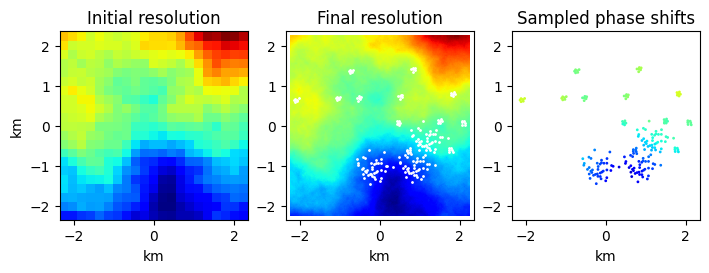

In [3]:
"""Generate a regular 2D phase screen for all of the pierce points"""

# Set parameters for the final, high resolution phase screen
#  - resolution of screen (metres)
res = 7.0
#  - width of screen (metres). Here it is square but it could be rectangular
screen_width = 1.001 * max(
    numpy.amax(x_pp) - numpy.amin(x_pp),
    numpy.amax(y_pp) - numpy.amin(y_pp),
)

# Generate a coarse Nside x Nside grid of ionospheric phase shifts with
# Kolmogorov turbulence

# Width of the coarse screen (pixels)
Nside0 = 21

# Will successively halve the resolution n_interp times, so figure out what
# n_interp and the initial coarse resolution need to be
res0_min = screen_width / (Nside0 - 1)
n_interp = numpy.ceil(numpy.log2(res0_min / res)).astype("int")
res0 = res * 2 ** n_interp

# Coordaintes of the coarse grid
x = numpy.arange(Nside0) * res0
y = numpy.arange(Nside0) * res0
xx, yy = numpy.meshgrid(x, y)

# Decompose the convariance matrix of pierce point phase shifts obeying
# the ionospheric structure function at some nominal frequency
freq_0 = 150e6
r_0 = 20e3          #  structure function diffractive scale at freq_0
beta = 5.0 / 3.0    #  structure function exponent
[evec_matrix, sqrt_evals] = decompose_phasescreen(xx, yy, r_0, beta)
n_points = xx.size

# Generate a random realisation of the coarse phase screen
screen0 = evec_matrix @ (sqrt_evals * numpy.random.randn(n_points))
screen0 = screen0.reshape(xx.shape)

# Successively interpolate the screen n_interp times
print(
    f"resolution = {res0:.0f} m,",
    f"need to divide by 2**{n_interp} to reach {res:.0f} m",
)

Nside = Nside0
res = res0
screen = screen0.copy()
for _ in range(n_interp):
    screen = interpolate_phasescreen(screen)
    screen = displace_phasescreen(screen, res, r_0, beta)
    Nside = 2 * Nside - 1
    res /= 2

print(
    f"final resolution = {res:.0f} m,",
    f"final grid = {Nside} x {Nside} pixels",
)

# Set some phase screen constants and extract the phase shifts from the grid
wl_scaling = freq_0 / emptyvis.frequency.data
i = ((x_pp + screen_width / 2) / res).astype("int")
j = ((y_pp + screen_width / 2) / res).astype("int")
pp_phase = screen[i, j]

figure()
subplots_adjust(left=0, right=1)
cmap = colormaps["jet"]

ax1 = subplot(131, aspect="equal")
ax1.set_title("Initial resolution")
ax1.set_xlabel("km")
ax1.set_ylabel("km")
x = res0 * numpy.arange(-(Nside0 // 2), Nside0 // 2 + 1) / 1e3
y = res0 * numpy.arange(-(Nside0 // 2), Nside0 // 2 + 1) / 1e3
pc = pcolor(x, y, screen0.T * 180.0 / numpy.pi, cmap=cmap)

ax2 = subplot(132, aspect="equal")
ax2.set_title("Final resolution")
ax2.set_xlabel("km")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
x = res * numpy.arange(-(Nside // 2), Nside // 2 + 1) / 1e3
y = res * numpy.arange(-(Nside // 2), Nside // 2 + 1) / 1e3
pc = pcolor(x, y, screen.T * 180.0 / numpy.pi, cmap=cmap)
scatter(x_pp/1e3, y_pp/1e3, s=1, c="w")

ax3 = subplot(133, aspect="equal")
ax3.set_title("Sampled phase shifts")
ax3.set_xlabel("km")
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())
scatter(
    x_pp/1e3, y_pp/1e3, s=1, c=pp_phase * 180.0 / numpy.pi, cmap=cmap,
    vmin=numpy.amin(screen) * 180.0 / numpy.pi,
    vmax=numpy.amax(screen) * 180.0 / numpy.pi,
)

print(f"Phase screen min = {numpy.amin(screen) * 180.0 / numpy.pi:+.1f} deg")
print(f"Phase screen max = {numpy.amax(screen) * 180.0 / numpy.pi:+.1f} deg")

The important quantity for visibilties is the relative phase shift between stations. On the right-hand side below the station phase shifts for each component are shown relative to the average shift of stations in the core. It is desireable for these to all be similar, so that the components can be combined into a single calibration model.

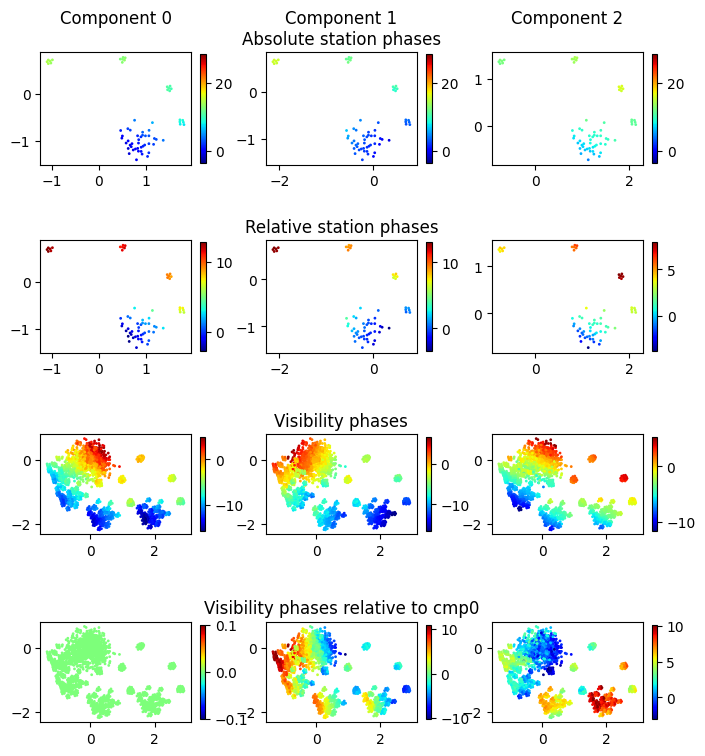

In [4]:
subplots_adjust(left=0, right=1, bottom=-0.5, top=1)

u = x_stn[emptyvis.antenna1.data] - x_stn[emptyvis.antenna2.data]
v = y_stn[emptyvis.antenna1.data] - y_stn[emptyvis.antenna2.data]

for cmp in range(n_components):
    cmp_idx0 = cmp * n_stations
    cmp_phase = pp_phase[cmp_idx0 : cmp_idx0 + n_stations]

    ax = subplot(4,n_components,0*n_components+cmp+1, aspect="equal")
    scatter(
        x_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
        y_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
        c=cmp_phase * 180.0 / numpy.pi,
        s=1, cmap=cmap,
        vmin=numpy.amin(screen) * 180.0 / numpy.pi,
        vmax=numpy.amax(screen) * 180.0 / numpy.pi,
    )
    cb = colorbar(shrink=0.7)
    if cmp == n_components // 2:
        title(f"Component {cmp}\nAbsolute station phases")
    else:
        title(f"Component {cmp}\n")

    ax = subplot(4,n_components,1*n_components+cmp+1, aspect="equal")
    scatter(
        x_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
        y_pp[cmp_idx0 : cmp_idx0 + n_stations]/1e3,
        c=(cmp_phase-numpy.mean(cmp_phase[cluster_id==0])) * 180.0 / numpy.pi,
        s=1, cmap=cmap,
    )
    cb = colorbar(shrink=0.7)
    if cmp == n_components // 2: title("Relative station phases")

    vis_phase = (
        cmp_phase[emptyvis.antenna1.data]
        - cmp_phase[emptyvis.antenna2.data]
    )

    ax = subplot(4,n_components,2*n_components+cmp+1, aspect="equal")
    scatter(u/1e3, v/1e3, s=1, c=vis_phase * 180.0 / numpy.pi, cmap=cmap)
    cb = colorbar(shrink=0.6)
    if cmp == n_components // 2: title("Visibility phases")

    if cmp == 0:
        vis_phase0 = vis_phase

    ax = subplot(4,n_components,3*n_components+cmp+1, aspect="equal")
    scatter(
        u/1e3, v/1e3, s=1,
        c=(vis_phase - vis_phase0) * 180.0 / numpy.pi, cmap=cmap,
    )
    cb = colorbar(shrink=0.6)
    if cmp == n_components // 2: title("Visibility phases relative to cmp0")

In [5]:
"""Set up a plotting function for the results"""

def plot_fit(screen, pp_phase, cmp_idx0, gain_table, ref_table=None):

    r2d = 180.0 / numpy.pi

    # cmap = colormaps["bone"]
    # cmap = colormaps["viridis"]
    cmap = colormaps["jet"]

    # Get the fitted phase shifts, scaled to the screen frequency
    chan = 0
    time = 0
    pol = 0
    fit = (
        numpy.angle(gain_table.gain.data[time, :, chan, pol, pol])
        / wl_scaling[chan]
    )
    if ref_table is not None:
        fit_ref = (
            numpy.angle(ref_table.gain.data[time, :, chan, pol, pol])
            / wl_scaling[chan]
        )

    # Extract the relevant phases and do phase referencing
    cmp_phase = pp_phase[cmp_idx0 : cmp_idx0 + n_stations]
    # Phase referencing against a single station:
    # pscreen = screen - cmp_phase[0]
    # ptrue = cmp_phase - cmp_phase[0]
    # pfit = fit - fit[0]
    # or against all of the core stations:
    pscreen = screen - numpy.mean(cmp_phase[cluster_id==0])
    ptrue = cmp_phase - numpy.mean(cmp_phase[cluster_id==0])
    pfit = fit - numpy.mean(fit[cluster_id==0])
    if ref_table is not None:
        pref = fit_ref - numpy.mean(fit_ref[cluster_id==0])

    c0a = numpy.amin(pscreen * r2d)
    c0b = numpy.amax(pscreen * r2d)

    # c0a = numpy.amin(ptrue * r2d)
    # c0b = numpy.amax(ptrue * r2d)

    x = x_pp[cmp_idx0 : cmp_idx0 + n_stations]
    y = y_pp[cmp_idx0 : cmp_idx0 + n_stations]

    xylim = (-screen_width/1.9e3, screen_width/1.9e3)

    def rms(x):
        return numpy.sqrt(numpy.mean(x**2))

    subplots_adjust(left=0, right=1, bottom=-0.15, top=0.85)

    ca = subplot(221, aspect="equal")
    ca.xaxis.set_ticklabels([])
    ca.set_xlim(xylim)
    ca.set_ylim(xylim)
    phase = numpy.array(ptrue).flatten() * r2d
    scatter(x/1e3, y/1e3, c=phase, s=5, marker='.', cmap=cmap, vmin=c0a, vmax=c0b)
    title("true, RMS=%.3f deg" % rms(phase))
    ylabel("north (km)")
    colorbar()
    # contour(xgrid, ygrid, pscreen.T * r2d, levels=10, colors="k")
    grid()

    ca = subplot(222, aspect="equal")
    ca.xaxis.set_ticklabels([])
    ca.yaxis.set_ticklabels([])
    ca.set_xlim(xylim)
    ca.set_ylim(xylim)
    phase = numpy.array(pfit).flatten() * r2d
    scatter(x/1e3, y/1e3, c=phase, s=5, marker='.', cmap=cmap, vmin=c0a, vmax=c0b)
    title("fit, RMS=%.3f deg" % rms(phase))
    colorbar()
    grid()

    ca = subplot(223, aspect="equal")
    ca.set_xlim(xylim)
    ca.set_ylim(xylim)
    phase = numpy.array(pfit.flatten() - ptrue.flatten()).flatten() * r2d
    max_err = numpy.amax(abs(phase))
    scatter(x/1e3, y/1e3, c=phase, s=5, marker='.', cmap=cmap)
    title("fit error, RMS=%.3f deg" % rms(phase))
    xlabel("east (km)")
    ylabel("north (km)")
    colorbar()
    grid()

    ca = subplot(224, aspect="equal")
    ca.yaxis.set_ticklabels([])
    ca.set_xlim(xylim)
    ca.set_ylim(xylim)
    if ref_table is None:
        xgrid = res * numpy.arange(-(Nside // 2), Nside // 2 + 1) / 1e3
        ygrid = res * numpy.arange(-(Nside // 2), Nside // 2 + 1) / 1e3
        pc = pcolor(xgrid, ygrid, pscreen.T * r2d, cmap=cmap, vmin=c0a, vmax=c0b)
        title("Input screen")
        xlabel("east (km)")
        colorbar(label="phase shift (deg)")
        # contour(xgrid, ygrid, pscreen.T * r2d, levels=10, colors="k")
        grid()
    else:
        phase = numpy.array(pfit.flatten() - pref.flatten()).flatten() * r2d
        max_err = numpy.amax(abs(phase))
        c0a = - max_err - 1e-12
        c0b = + max_err + 1e-12
        scatter(x/1e3, y/1e3, c=phase, s=5, marker='.', cmap=cmap, vmin=c0a, vmax=c0b)
        title("fit diff, RMS=%.3f deg" % rms(phase))
        xlabel("east (km)")
        colorbar()
        grid()

The first demonstration has a simple, single component calibrator.

Note in the bottom left panel that the phase shifts have been contrained to within a few percent.

INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]


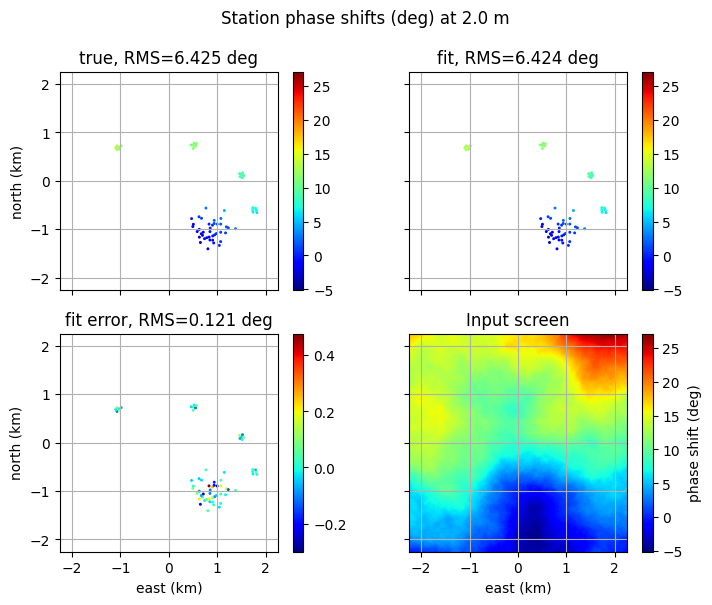

In [6]:
"""Generate true and model visibilties with and without
ionospheric phase corruptions"""

# For the first run, just use the strongest component in isolation

# Initialise the visibility data and model
emptyvis.vis.data *= 0.0
vis = emptyvis.copy(deep=True)
modelvis = emptyvis.copy(deep=True)

# Predict the first component into temporary storage
cmp = 0
flux_density = I0[cmp] * (frequency / frequency[0]) ** alpha[cmp]
tmpvis = dft_skycomponent_visibility(
    emptyvis,
    SkyComponent(
        direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
        frequency=frequency,
        name=f"component-{cmp}",
        flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
        polarisation_frame=PolarisationFrame("stokesI"),
    ),
)

# Calculate visibility phase shifts for this component
cmp_idx0 = cmp * n_stations
vis_phase = (
    pp_phase[cmp_idx0 + vis.antenna1.data]
    - pp_phase[cmp_idx0 + vis.antenna2.data]
)
# Add predicted visibilities to the main arrays
#  - need to handle time and polarisation better than this...
time = 0
pol = 0
modelvis.vis.data[time, :, :, pol] += tmpvis.vis.data[time, :, :, pol]
vis.vis.data[time, :, :, pol] += (
    tmpvis.vis.data[time, :, :, pol] * numpy.exp(
        1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
    )
)

# Solve cluster parameters and convert to gain_table station phase shifts
gain_table1 = solve_ionosphere(
    vis,
    modelvis,
    low_config.xyz.data,
    cluster_id,
)

# Plot fitted phase shifts relative to those of component 0
cmp_idx0 = 0 * n_stations
fig = figure()
fig.suptitle(f"Station phase shifts (deg) at {const.c.value/freq_0:.1f} m")
plot_fit(screen, pp_phase, cmp_idx0, gain_table1)

Next is a demonstrate of a multi-component calibrator, but with the same ionospheric phase shift for all components. The common, direction-independent phase shifts used were the same as those used in the single-component example above, and note in the bottom left panel that the fit residuals are effectively the same.

INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]


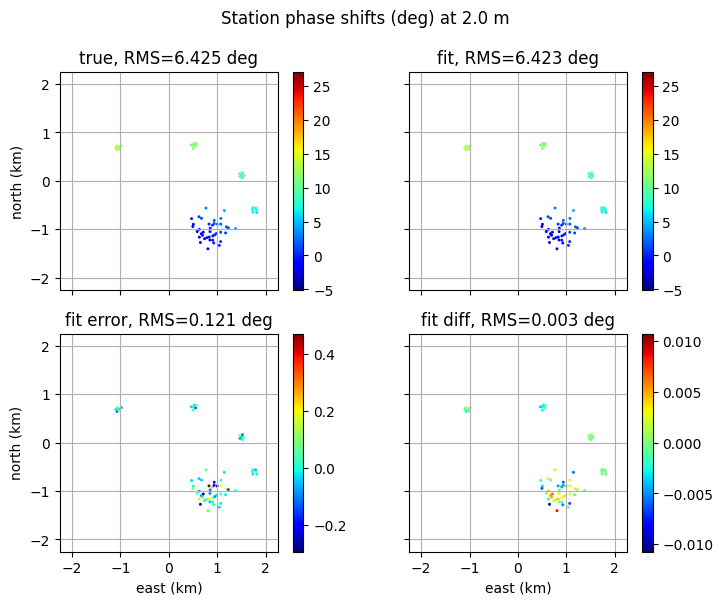

In [7]:
"""Generate true and model visibilties with and without
ionospheric phase corruptions"""

# Next simulate all components, but just use the same ionospheric phase
# shift for all of them

# Initialise the visibility data and model
emptyvis.vis.data *= 0.0
vis = emptyvis.copy(deep=True)
modelvis = emptyvis.copy(deep=True)

# Predicted components one at a time to allow for direction dependence
for cmp in range(n_components):

    # Predict this component into temporary storage
    # emptyvis data should be overwritten but set to zero anyway
    emptyvis.vis.data *= 0.0
    flux_density = I0[cmp] * (frequency / frequency[0]) ** alpha[cmp]
    tmpvis = dft_skycomponent_visibility(
        emptyvis, 
        SkyComponent(
            direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
            frequency=frequency,
            name=f"component-{cmp}",
            flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
            polarisation_frame=PolarisationFrame("stokesI"),
        ),
    )

    # Calculate visibility phase shifts for this component
    # Recall that in this demo the same phase shifts are being used for all
    cmp_idx0 = 0 * n_stations
    vis_phase = (
        pp_phase[cmp_idx0 + vis.antenna1.data]
        - pp_phase[cmp_idx0 + vis.antenna2.data]
    )
    # Add predicted visibilities to the main arrays
    #  - need to handle time and polarisation better than this...
    time = 0
    pol = 0
    modelvis.vis.data[time, :, :, pol] += tmpvis.vis.data[time, :, :, pol]
    vis.vis.data[time, :, :, pol] += (
        tmpvis.vis.data[time, :, :, pol] * numpy.exp(
            1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
        )
    )

# Solve cluster parameters and convert to gain_table station phase shifts
gain_table2 = solve_ionosphere(
    vis,
    modelvis,
    low_config.xyz.data,
    cluster_id,
)

# Plot fitted phase shifts relative to those of component 0
cmp_idx0 = 0 * n_stations
fig = figure()
fig.suptitle(f"Station phase shifts (deg) at {const.c.value/freq_0:.1f} m")
plot_fit(screen, pp_phase, cmp_idx0, gain_table2, gain_table1)

When the previous demonstration is repeated with individual phase shifts for each component of the calibrator, the errors increase, as one might expect. When direction-dependent errors become too large, the components need to be split into multiple calibrators and solved separately. This is considered in YAN-1312.

INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]


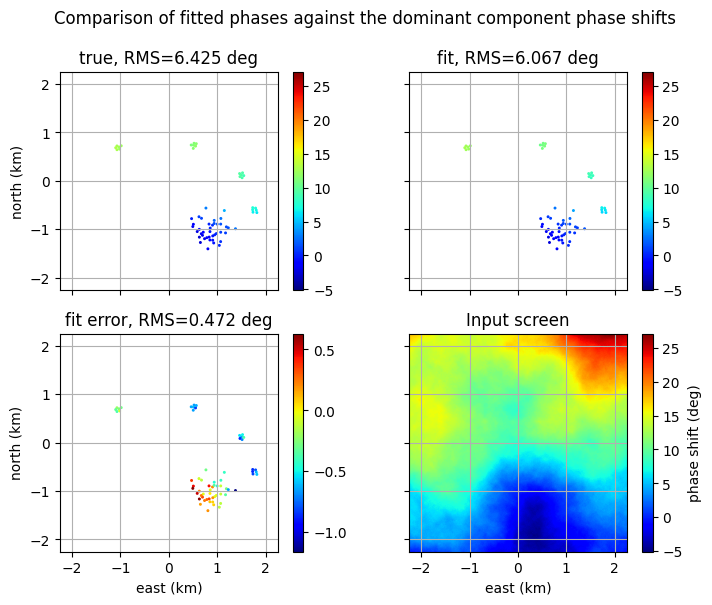

In [8]:
"""Generate true and model visibilties with and without
ionospheric phase corruptions"""

# Next simulate the components with their own ionospheric phase shifts.
# This has DD effects so should not be as accurate.

# Initialise the visibility data and model
emptyvis.vis.data *= 0.0
vis = emptyvis.copy(deep=True)
modelvis = emptyvis.copy(deep=True)

# Predicted components one at a time to allow for direction dependence
for cmp in range(n_components):

    # Predict this component into temporary storage
    # emptyvis data should be overwritten but set to zero anyway
    emptyvis.vis.data *= 0.0
    flux_density = I0[cmp] * (frequency / frequency[0]) ** alpha[cmp]
    tmpvis = dft_skycomponent_visibility(
        emptyvis,
        SkyComponent(
            direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
            frequency=frequency,
            name=f"component-{cmp}",
            flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
            polarisation_frame=PolarisationFrame("stokesI"),
        ),
    )

    # Calculate visibility phase shifts for this component
    cmp_idx0 = cmp * n_stations
    vis_phase = (
        pp_phase[cmp_idx0 + vis.antenna1.data]
        - pp_phase[cmp_idx0 + vis.antenna2.data]
    )
    # Add predicted visibilities to the main arrays
    #  - need to handle time and polarisation better than this...
    time = 0
    pol = 0
    modelvis.vis.data[time, :, :, pol] += tmpvis.vis.data[time, :, :, pol]
    vis.vis.data[time, :, :, pol] += (
        tmpvis.vis.data[time, :, :, pol] * numpy.exp(
            1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
        )
    )

# Solve cluster parameters and convert to gain_table station phase shifts
gain_table3 = solve_ionosphere(
    vis,
    modelvis,
    low_config.xyz.data,
    cluster_id,
)

# Plot fitted phase shifts relative to those of component 0
cmp_idx0 = 0 * n_stations
fig = figure()
fig.suptitle("Comparison of fitted phases against the dominant component phase shifts")
plot_fit(screen, pp_phase, cmp_idx0, gain_table3)
#fig = figure()
#fig.suptitle("Comparison of fitted phases against weighted averaged phase shifts")
#plot_fit(screen, pp_phase, cmp_idx0, ???)

In this final demonstration, source morphology is added to the multi-component calibration model. Here we will revert to common, direction-independent phase shifts so that we can compare the results with previous sky models. Note again the equivalence of the residuals in bottom left panel.

INFO:func-python-logger:Setting up iono solver for 64 stations in 5 cluster
INFO:func-python-logger:There are 28 total parameters: 16 in c[0] + 3 x c[1:4]


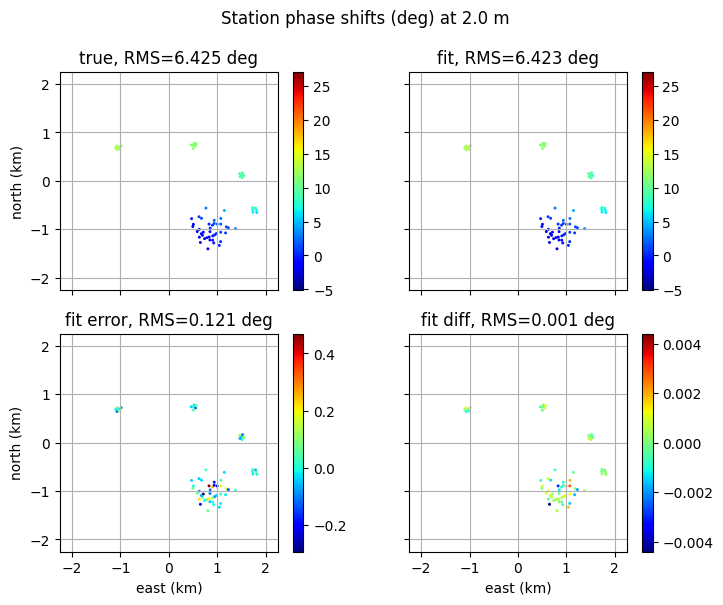

In [9]:
"""Generate true and model visibilties with and without
ionospheric phase corruptions"""

# Next simulate all components, again with a common ionospheric phase shift
# for all components but with some component morphology

# Initialise the visibility data and model
emptyvis.vis.data *= 0.0
vis = emptyvis.copy(deep=True)
modelvis = emptyvis.copy(deep=True)

# ska_sdp_datamodels.sky_model.SkyComponent has the option shape="Gaussian",
# but it doesn't seem to be implemented (check though). Just do it here
# directly as uv tapers, and to keep it simple just make them circular.

# Set a Gaussian shape for each component
# Set the image FWHM in arcmin and convert to radians
FWHM = numpy.array([1.0, 0.4, 0.7]) * numpy.pi / 10800.0

# Precalculate the taper exponent, except for the uv factor in metres
# and the component-dependent FWHM
# exp(-a*l^2) imparts a uv taper of exp(-pi^2/a*u^2)
# a = 1/(2*(FWHM/(2*sqrt(2*log(2))))^2) = 4*log(2)/FWHM^2
# => taper = exp(-pi^2*FWHM^2/(4*log(2)) * (u_m/wl)^2)
wl = const.c.value / tmpvis.frequency.data
taper_const = - numpy.pi**2 / (4.0*numpy.log(2.0)) / wl**2

# Predicted components one at a time to allow for direction dependence
for cmp in range(n_components):

    # Predict this component into temporary storage
    # emptyvis data should be overwritten but set to zero anyway
    emptyvis.vis.data *= 0.0
    flux_density = I0[cmp] * (frequency / frequency[0]) ** alpha[cmp]
    tmpvis = dft_skycomponent_visibility(
        emptyvis, 
        SkyComponent(
            direction=SkyCoord(ra=ra[cmp], dec=dec[cmp]),
            frequency=frequency,
            name=f"component-{cmp}",
            flux=flux_density[:, numpy.newaxis],  # add the polarisation axis
            polarisation_frame=PolarisationFrame("stokesI"),
        ),
    )

    # Calculate visibility attenuation due to component morphology
    vis_atten = numpy.exp(
        numpy.einsum(
            "b,f->bf",
            tmpvis.uvw.data[0,:,0]**2 + tmpvis.uvw.data[0,:,1]**2,
            taper_const * FWHM[cmp]**2,
        )
    )

    # Calculate visibility phase shifts for this component
    # Recall that in this demo the same phase shifts are being used for all
    cmp_idx0 = 0 * n_stations
    vis_phase = (
        pp_phase[cmp_idx0 + vis.antenna1.data]
        - pp_phase[cmp_idx0 + vis.antenna2.data]
    )

    # Add predicted visibilities to the main arrays
    #  - need to handle time and polarisation better than this...
    time = 0
    pol = 0
    modelvis.vis.data[time, :, :, pol] += (
        tmpvis.vis.data[time, :, :, pol] * vis_atten
    )
    vis.vis.data[time, :, :, pol] += (
        tmpvis.vis.data[time, :, :, pol] * vis_atten * numpy.exp(
            1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
        )
    )

# Solve cluster parameters and convert to gain_table station phase shifts
gain_table4 = solve_ionosphere(
    vis,
    modelvis,
    low_config.xyz.data,
    cluster_id,
)

# Plot fitted phase shifts relative to those of component 0
cmp_idx0 = 0 * n_stations
fig = figure()
fig.suptitle(f"Station phase shifts (deg) at {const.c.value/freq_0:.1f} m")
plot_fit(screen, pp_phase, cmp_idx0, gain_table4, gain_table2)